In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.activations import leaky_relu
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from YAD2K.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [2]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Pc
    box_scores = np.multiply(box_confidence, box_class_probs)
    
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    filter_mask = K.greater_equal(box_class_scores, threshold)
    
    scores = tf.boolean_mask(box_class_scores, filter_mask)
    boxes = tf.boolean_mask(boxes, filter_mask)
    classes = tf.boolean_mask(box_classes, filter_mask)
    
    return scores, boxes, classes    

In [3]:
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)


(<tf.Tensor: shape=(1786,), dtype=float32, numpy=
 array([21.294851, 62.658787, 16.064978, ..., 33.62834 , 54.689083,
        58.749218], dtype=float32)>,
 <tf.Tensor: shape=(1786, 4), dtype=float32, numpy=
 array([[ 2.88381   ,  2.9140406 , -0.03477657,  2.7024395 ],
        [ 4.01801   ,  7.102514  , -1.421094  , -1.1415017 ],
        [ 1.0273384 , -2.1178942 ,  4.8872733 , -4.0143332 ],
        ...,
        [-0.27290797,  7.283095  ,  5.799567  , -1.5821693 ],
        [-0.98508644, -2.4997838 ,  7.1540446 , -5.151011  ],
        [ 8.872453  , -0.37440765,  0.8893236 ,  3.25239   ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1786,), dtype=int64, numpy=array([32, 73, 78, ..., 15, 73, 44], dtype=int64)>)

In [4]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1)*(yi2 - yi1)


    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)

    box1_area = (box1[3] - box1[1])*(box1[2]- box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area

    
    # compute the IoU
  
    iou = inter_area / union_area


    return iou

In [5]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    selected_indices = tf.image.non_max_suppression(boxes, scores, tf.convert_to_tensor(max_boxes), iou_threshold = 0.5)
    
    scores = K.gather(scores, selected_indices)
    boxes = K.gather(boxes, selected_indices)
    classes = K.gather(classes, selected_indices)

    return scores, boxes, classes

In [7]:
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = tf.Tensor(6.082263, shape=(), dtype=float32)
boxes[2] = tf.Tensor([ 4.110873   2.544206   2.1469054 -1.5198021], shape=(4,), dtype=float32)
classes[2] = tf.Tensor(5.049652, shape=(), dtype=float32)
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [8]:
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
        
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs)
    
    boxes = scale_boxes(boxes, image_shape)
    
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    
    return scores.numpy(), boxes.numpy(), classes.numpy()

In [10]:
yolo_outputs = (tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = ", scores[2])
print("boxes[2] = ", boxes[2])
print("classes[2] = ", classes[2])
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = ", classes.shape)

scores[2] =  147.72488
boxes[2] =  [2651.31   1417.04   1748.9335 7298.7256]
classes[2] =  74
scores.shape =  (10,)
boxes.shape =  (10, 4)
classes.shape =  (10,)


In [68]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)  

In [69]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, BatchNormalization, LeakyReLU, Reshape, Flatten, Dense
from keras.models import load_model, Model


yolo_model = load_model('YAD2K\model_data\yolov2.h5')
yolo_model.summary()
# Load the converted weights
#weights_path = 'YAD2K\model_data\yolov2.h5'
#yolo_model.load_weights(weights_path)
#yolo_model.summary()

C:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
C:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\lambda_layer.py:331: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  output_shape = cls._parse_function_from_config(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 conv2d_8 (Conv2D)              (None, 38, 38, 512)  1179648     ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 38, 38, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 38, 38, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 38, 38, 256)  131072      ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 38, 38, 256)  1024       ['conv2d_9[0][0]']               
 rmalizati

                                                                                                  
 conv2d_20 (Conv2D)             (None, 38, 38, 64)   32768       ['leaky_re_lu_12[0][0]']         
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 19, 19, 1024  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 38, 38, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 19, 19, 1024  9437184     ['leaky_re_lu_18[0][0]']         
          

In [70]:
image, image_data = preprocess_image("YAD2K/images/car.jpg", model_image_size = (608, 608))

In [71]:
image_data.shape

(1, 608, 608, 3)

In [72]:
output = yolo_model.predict([image_data])

1/1 [==============================] - 2s 2s/step


In [73]:
output = tf.convert_to_tensor(output)

In [74]:
yolo_outputs = yolo_head(output, anchors, len(class_names))
scores, boxes, classes =  yolo_eval(yolo_outputs, image_shape)

In [75]:
scores

array([0.8666102], dtype=float32)

Found 1 boxes for car.jpg
car 0.87 (673, 506) (883, 585)


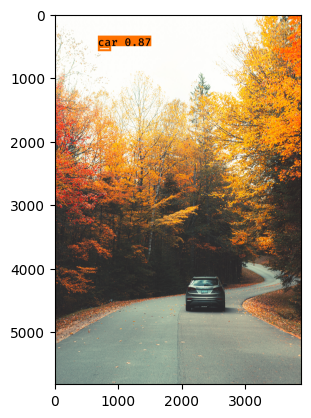

In [76]:
"""
    When have to train this yolov2 model for the better prediction, right now it is giving the bad accuracy and we need
    high computation system for to train it.

"""
from matplotlib.pyplot import imread
# Print predictions info
car = "car.jpg"
print('Found {} boxes for {}'.format(len(boxes), car))
# Generate colors for drawing bounding boxes.
colors = generate_colors(class_names)
# Draw bounding boxes on the image file
draw_boxes(image, scores, boxes, classes, class_names, colors)
# Save the predicted bounding box on the image
image.save("output.jpg", quality=90)
# Display the results in the notebook
output_image = imread("output.jpg")
imshow(output_image)